# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

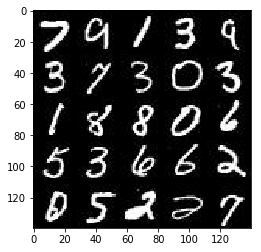

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

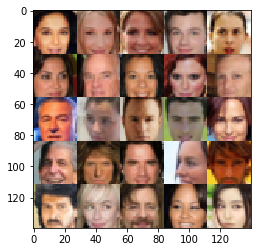

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
            
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    
 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                sample_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, input_z: sample_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        input_z: sample_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: sample_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0690... Generator Loss: 8.4966
Epoch 1/2... Discriminator Loss: 3.4889... Generator Loss: 0.0330
Epoch 1/2... Discriminator Loss: 0.0659... Generator Loss: 3.1485
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 2.3530
Epoch 1/2... Discriminator Loss: 5.0017... Generator Loss: 0.0123
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 1.7374
Epoch 1/2... Discriminator Loss: 0.7113... Generator Loss: 3.5423
Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 1.5651
Epoch 1/2... Discriminator Loss: 0.3068... Generator Loss: 2.4240
Epoch 1/2... Discriminator Loss: 0.2628... Generator Loss: 2.5528


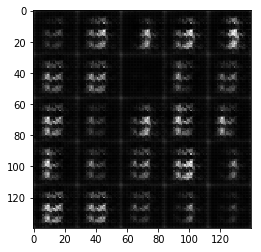

Epoch 1/2... Discriminator Loss: 0.3316... Generator Loss: 3.8380
Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 1.3278
Epoch 1/2... Discriminator Loss: 0.2517... Generator Loss: 4.1059
Epoch 1/2... Discriminator Loss: 0.3900... Generator Loss: 1.4630
Epoch 1/2... Discriminator Loss: 0.3127... Generator Loss: 3.2628
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 3.4336
Epoch 1/2... Discriminator Loss: 0.5042... Generator Loss: 1.5329
Epoch 1/2... Discriminator Loss: 2.1781... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 0.4815... Generator Loss: 2.1295
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.2431


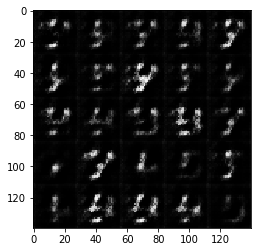

Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 2.1426
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.9313
Epoch 1/2... Discriminator Loss: 1.5283... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 0.6950... Generator Loss: 2.5169
Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.8361
Epoch 1/2... Discriminator Loss: 1.3237... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.2744
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 2.4281


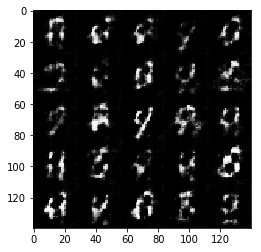

Epoch 1/2... Discriminator Loss: 0.6767... Generator Loss: 2.3064
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.1388... Generator Loss: 0.5573
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 1.7824
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.7166
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.5603... Generator Loss: 0.3500
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.6090
Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.7305


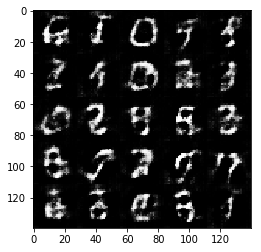

Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 1.3765... Generator Loss: 0.4482
Epoch 1/2... Discriminator Loss: 1.3082... Generator Loss: 1.9317
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 2.3442
Epoch 1/2... Discriminator Loss: 1.0017... Generator Loss: 1.2480
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.2142... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.6158


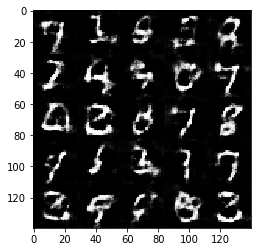

Epoch 1/2... Discriminator Loss: 1.3326... Generator Loss: 0.4570
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 2.0077
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 1.1227... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.5196... Generator Loss: 0.3442
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 0.6313


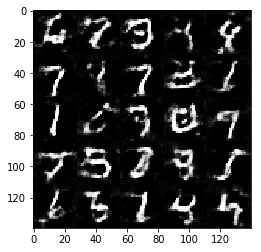

Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.5401
Epoch 1/2... Discriminator Loss: 0.9841... Generator Loss: 1.4961
Epoch 1/2... Discriminator Loss: 0.9712... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.0237... Generator Loss: 0.9832
Epoch 1/2... Discriminator Loss: 1.0725... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 0.8811
Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 0.9914... Generator Loss: 1.4878


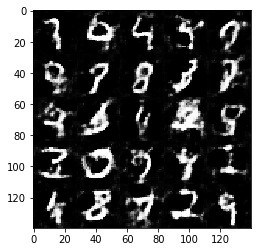

Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 0.9908... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 1.1184... Generator Loss: 0.5883
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 1.5252
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 1.4341
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.3889
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 1.7507
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.3529
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 0.6560


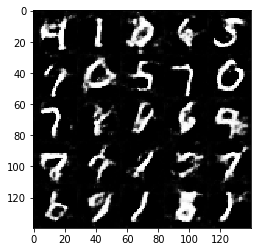

Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.2959
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 0.9362... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 1.8450
Epoch 1/2... Discriminator Loss: 1.0041... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 1.6538
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.6309
Epoch 1/2... Discriminator Loss: 1.0489... Generator Loss: 0.6534


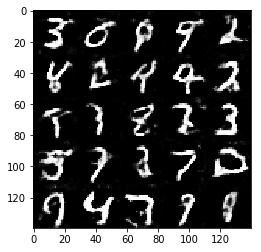

Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.3484
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 0.8342
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.5179
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 1.3067
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 0.8909... Generator Loss: 1.0018
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.5019... Generator Loss: 0.3456
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 1.4215
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 1.9617


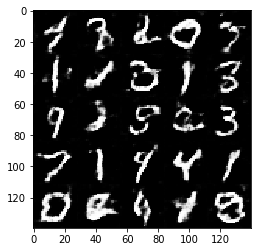

Epoch 2/2... Discriminator Loss: 0.9632... Generator Loss: 0.7696
Epoch 2/2... Discriminator Loss: 2.0928... Generator Loss: 0.2095
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.4247
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.7087... Generator Loss: 0.3049
Epoch 2/2... Discriminator Loss: 1.1957... Generator Loss: 0.5241
Epoch 2/2... Discriminator Loss: 1.0844... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 1.4855... Generator Loss: 0.3416
Epoch 2/2... Discriminator Loss: 1.4600... Generator Loss: 0.3241


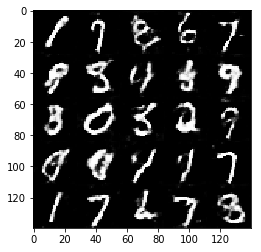

Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.6568
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 1.7067
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.4832
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 1.8392
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.4113
Epoch 2/2... Discriminator Loss: 0.8585... Generator Loss: 0.8145
Epoch 2/2... Discriminator Loss: 0.7745... Generator Loss: 1.0779
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 0.9019... Generator Loss: 1.6544
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 0.9717


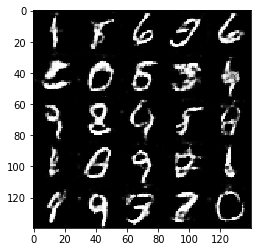

Epoch 2/2... Discriminator Loss: 0.9154... Generator Loss: 0.7328
Epoch 2/2... Discriminator Loss: 0.8108... Generator Loss: 1.0525
Epoch 2/2... Discriminator Loss: 1.1830... Generator Loss: 1.5890
Epoch 2/2... Discriminator Loss: 1.4735... Generator Loss: 0.3428
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.2358
Epoch 2/2... Discriminator Loss: 0.8897... Generator Loss: 1.2456
Epoch 2/2... Discriminator Loss: 1.0167... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 0.8702... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.5420


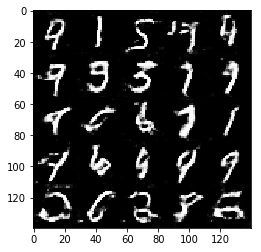

Epoch 2/2... Discriminator Loss: 0.8912... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 1.7014... Generator Loss: 3.4254
Epoch 2/2... Discriminator Loss: 0.9922... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 0.9277... Generator Loss: 1.6172
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.3655... Generator Loss: 0.4044
Epoch 2/2... Discriminator Loss: 2.0687... Generator Loss: 0.1694
Epoch 2/2... Discriminator Loss: 0.9355... Generator Loss: 0.6925
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 0.7441
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 1.5845


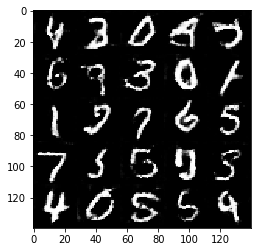

Epoch 2/2... Discriminator Loss: 0.7817... Generator Loss: 1.7309
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.2905
Epoch 2/2... Discriminator Loss: 0.7937... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.4216
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 2.1328
Epoch 2/2... Discriminator Loss: 0.7808... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 0.8568... Generator Loss: 1.4158
Epoch 2/2... Discriminator Loss: 1.8429... Generator Loss: 2.2598
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.0139


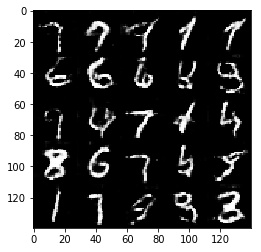

Epoch 2/2... Discriminator Loss: 0.9967... Generator Loss: 0.6567
Epoch 2/2... Discriminator Loss: 2.1418... Generator Loss: 0.2109
Epoch 2/2... Discriminator Loss: 1.6494... Generator Loss: 0.2961
Epoch 2/2... Discriminator Loss: 1.7668... Generator Loss: 0.2694
Epoch 2/2... Discriminator Loss: 0.6704... Generator Loss: 1.0716
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 0.4450
Epoch 2/2... Discriminator Loss: 1.3193... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 0.8821... Generator Loss: 2.1669
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 1.0078
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.4384


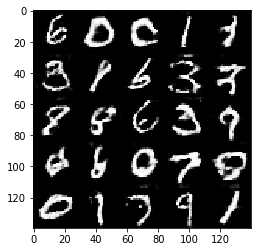

Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 0.8788... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.7475... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.6215
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 0.4530
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.6225
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.5715
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.1082
Epoch 2/2... Discriminator Loss: 1.4284... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 0.8047


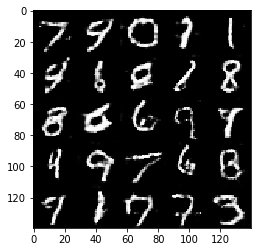

Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.3837
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 0.6549... Generator Loss: 0.9632
Epoch 2/2... Discriminator Loss: 0.7131... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 0.7648
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.7047
Epoch 2/2... Discriminator Loss: 0.6962... Generator Loss: 0.9749
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.4558
Epoch 2/2... Discriminator Loss: 0.6213... Generator Loss: 1.6200
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.5180


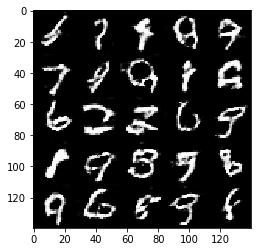

Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.5014
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 0.6204... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 2.3149... Generator Loss: 0.1692
Epoch 2/2... Discriminator Loss: 1.3416... Generator Loss: 0.4933
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.4968


In [12]:
batch_size = 64
z_dim = 100
learning_rate = .0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.0784... Generator Loss: 4.9461
Epoch 1/1... Discriminator Loss: 0.2701... Generator Loss: 5.4641
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 1.6347... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 2.0281... Generator Loss: 0.2480


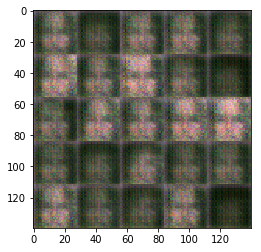

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.7319... Generator Loss: 1.3112
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.3957
Epoch 1/1... Discriminator Loss: 1.8064... Generator Loss: 0.3193
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.6416
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.5594
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 2.0689
Epoch 1/1... Discriminator Loss: 1.6373... Generator Loss: 0.4278


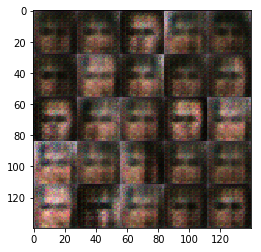

Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.0799
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 1.4057
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 1.1734
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 1.8075
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.2645


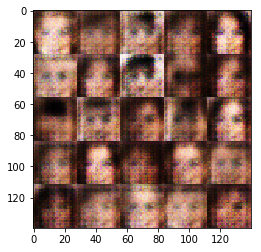

Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.0886
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 1.4716
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.7060


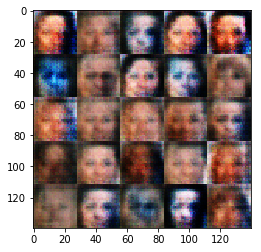

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7645
Epoch 1/1... Discriminator Loss: 1.6890... Generator Loss: 0.3833
Epoch 1/1... Discriminator Loss: 1.3156... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1755


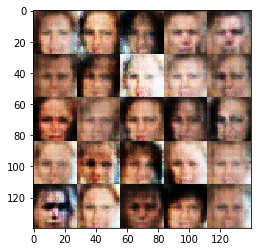

Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.3001
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.1392... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.3176
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.8712... Generator Loss: 0.2225
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.6941


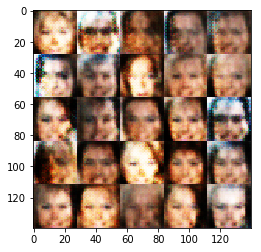

Epoch 1/1... Discriminator Loss: 1.1061... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 0.9548... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.5040... Generator Loss: 1.6824
Epoch 1/1... Discriminator Loss: 2.0757... Generator Loss: 0.1712
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 2.1039
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 1.0881
Epoch 1/1... Discriminator Loss: 1.7877... Generator Loss: 2.3063


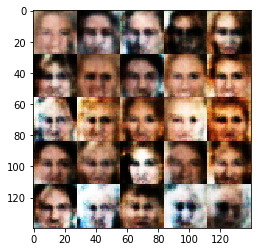

Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.3651
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 2.4949
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.2911
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 1.5380
Epoch 1/1... Discriminator Loss: 1.9200... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 0.7918


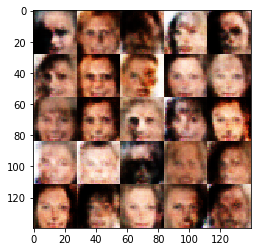

Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 0.8727... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.8107... Generator Loss: 2.4009


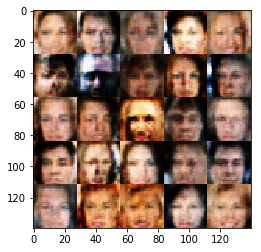

Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.0245... Generator Loss: 2.1038
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.4118
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 2.3355
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 2.5073... Generator Loss: 0.1120


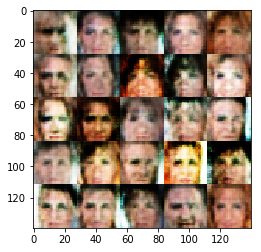

Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.3521
Epoch 1/1... Discriminator Loss: 0.9912... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.7073... Generator Loss: 0.2716
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.3582
Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6425


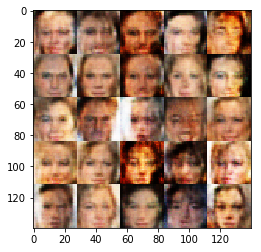

Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 2.6732... Generator Loss: 0.0878
Epoch 1/1... Discriminator Loss: 1.0531... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8966
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 2.2151... Generator Loss: 0.1490
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.5551


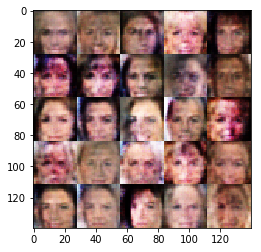

Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.5392
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.4035
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 2.0002
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.3299
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 1.5485
Epoch 1/1... Discriminator Loss: 1.1570... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 1.0474


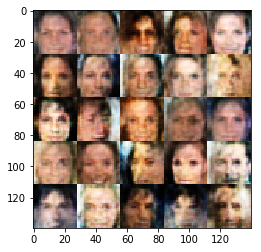

Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.6768
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.4616
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 1.2962
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8367


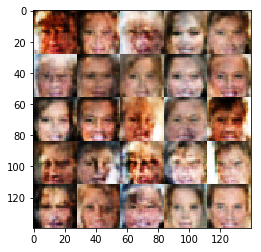

Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 1.5511
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.3344


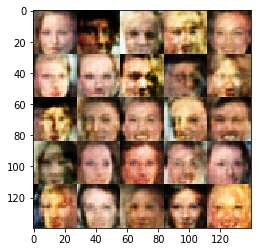

Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.6061... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 0.9530... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.7837


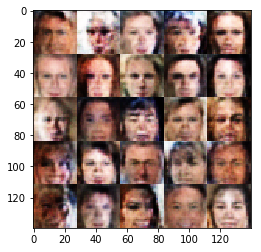

Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.1622
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.4660
Epoch 1/1... Discriminator Loss: 1.1033... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.9895
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 1.1977
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.4360


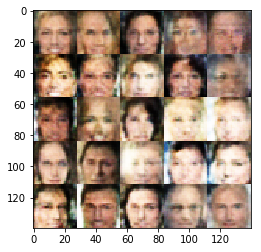

Epoch 1/1... Discriminator Loss: 1.0687... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.5429
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.3837
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.3572
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8813


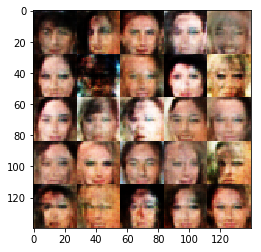

Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9929
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 1.7554
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.4668
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.2472
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.5725


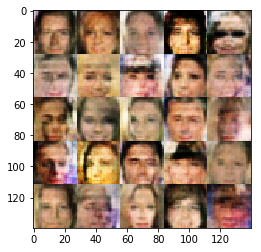

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2563... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 1.4591
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6704


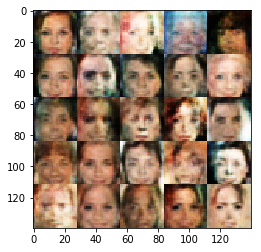

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 2.0579
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 1.5096
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.5252
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 0.9034


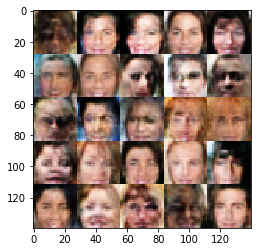

Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 0.9776
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.4597
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.4189
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 1.5538
Epoch 1/1... Discriminator Loss: 0.9662... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0105... Generator Loss: 1.4536
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.0597


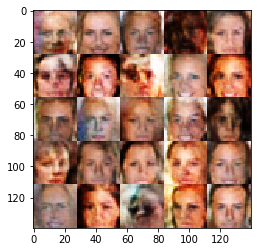

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.5535
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 1.0869... Generator Loss: 1.3469
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.2072
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.4886


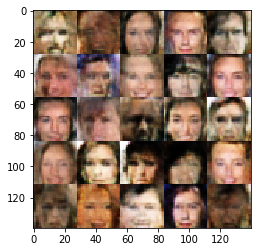

Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 1.4504
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 1.2700
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 2.0142
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.2086
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 0.4815


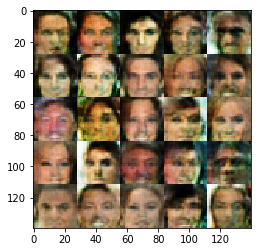

Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 1.2436
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9971
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.7797... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.4913
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.3513
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.5819


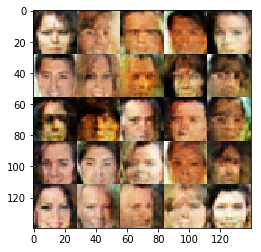

Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0699... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.3192
Epoch 1/1... Discriminator Loss: 0.9517... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.3479
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.2799
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.4589


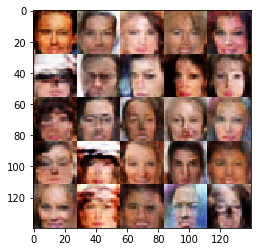

Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 0.9281... Generator Loss: 1.3198
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6150


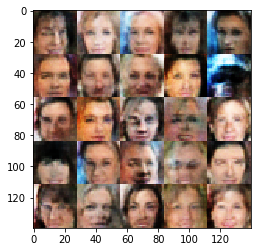

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 0.8427... Generator Loss: 1.3658
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.4009
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.8199


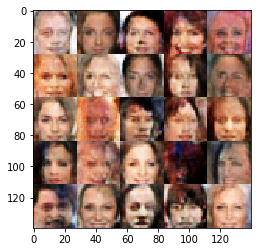

Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.3527
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1178
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.4752
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.4209
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.4774
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.7219


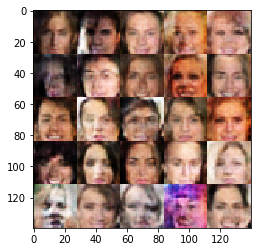

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.4430
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.4131
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.0487
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.0265


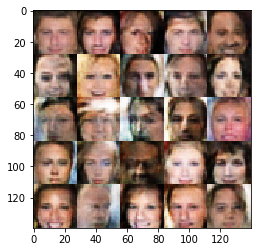

Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 1.3831
Epoch 1/1... Discriminator Loss: 0.9708... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.4782
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 1.5427
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.5498


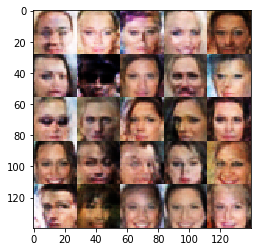

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.3163
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.3281
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.2831
Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7510


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1 

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.